<img src='figures/notebook/normal_vision.jpg'>

<img src='figures/notebook/diabetic_vision.jpg'>

# Retina Nerve Segmentation: Preventing Blindness with Deep Learning

In [1]:
%matplotlib inline

In [2]:
from myutils import *

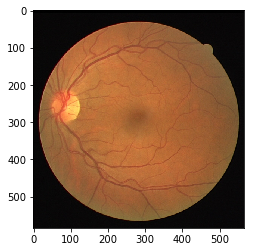

In [3]:
show_test_image()

## Step 1: Initialize the Network

<img src='figures/notebook/EliottNet.png'>

In [4]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D 
from keras.layers import Dropout 
from keras.layers import Flatten 
from keras.layers import Dense  

from keras import backend as K
K.set_image_dim_ordering('th')

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [5]:
def EliottNet():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(1,31,31), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(20,(3,3), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dense(units=2, activation='softmax', kernel_initializer='glorot_uniform'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
import numpy as np
seed = 7
np.random.seed(seed) # configure the random number generator to have reproductible results
model = EliottNet()

## Step 2: Train the Network

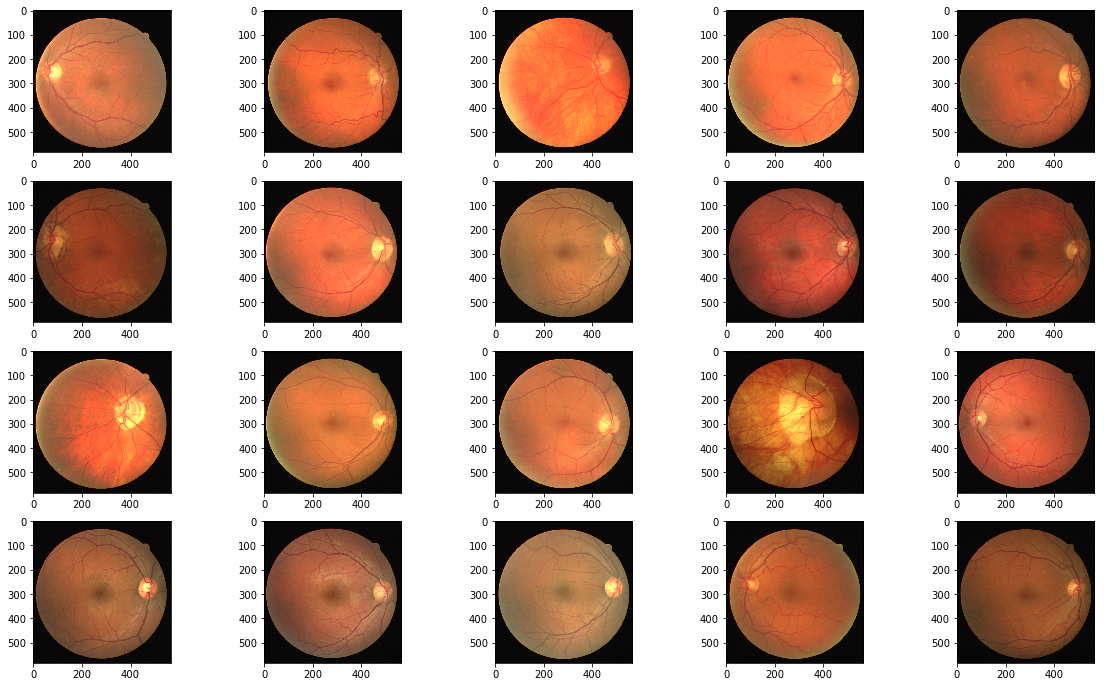

In [7]:
show_training_images()

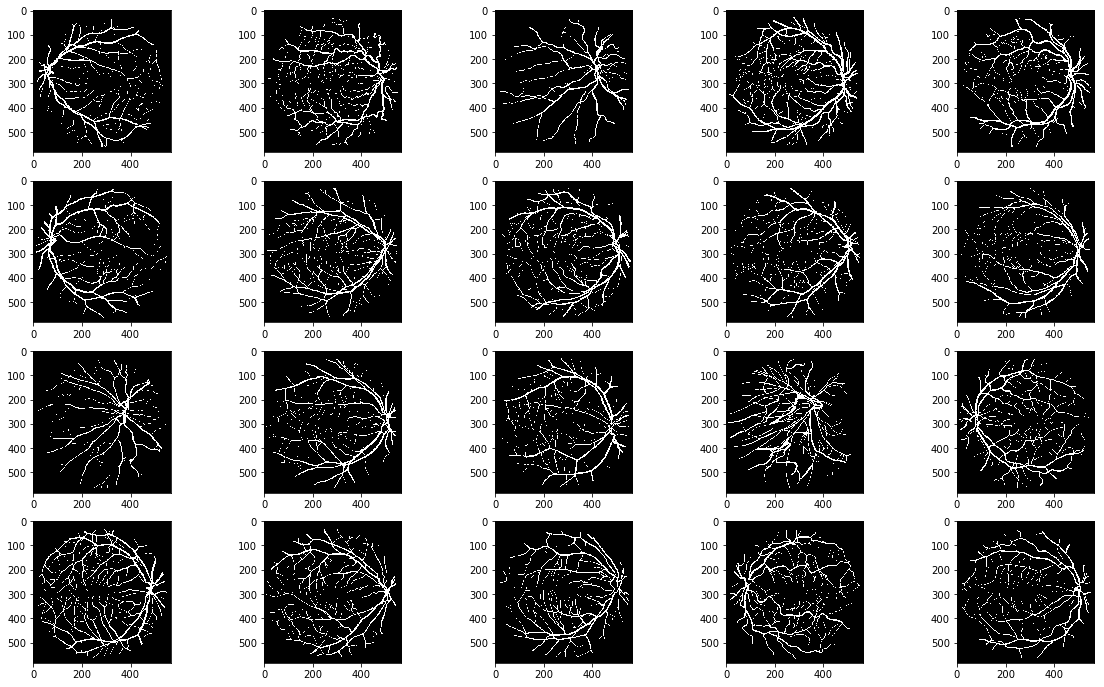

In [8]:
show_training_segmentations()

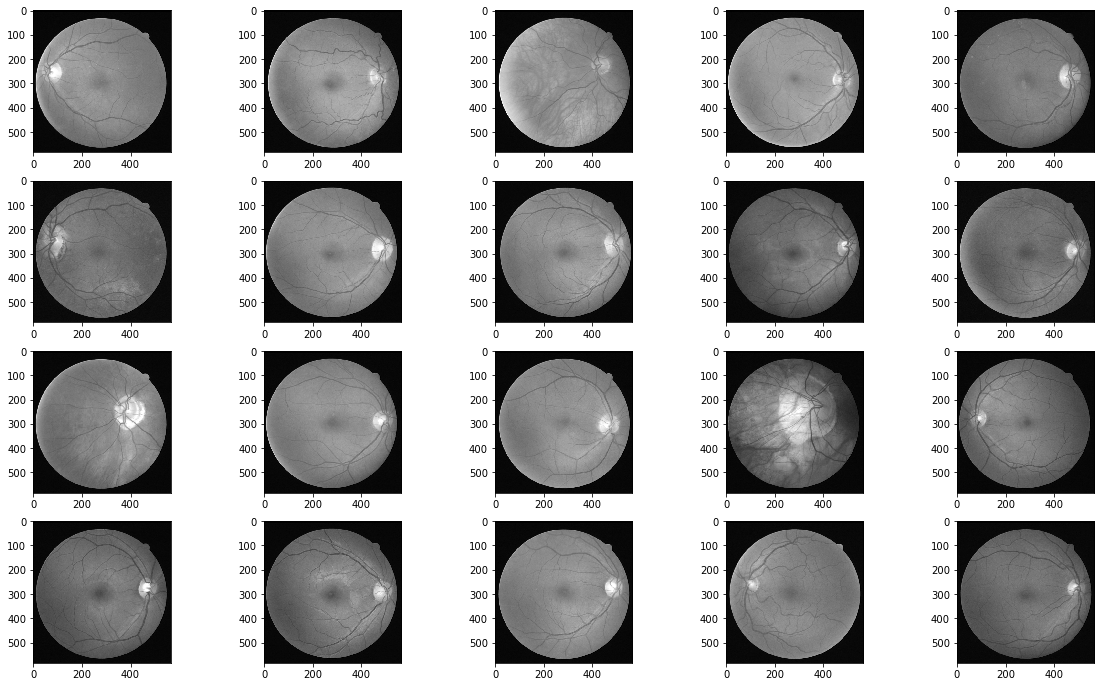

In [9]:
convert_training_to_grayscale()

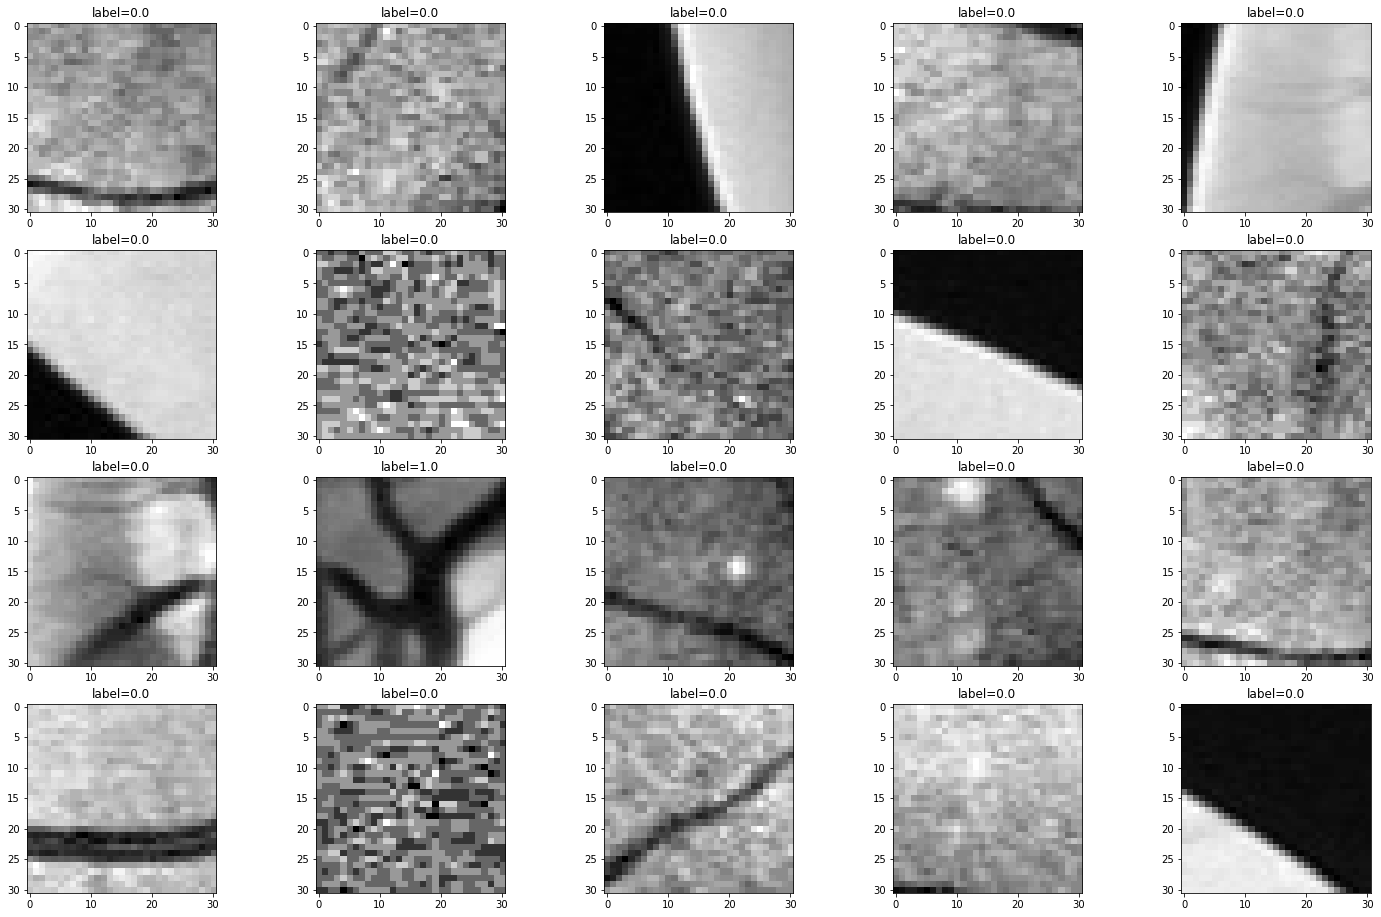

In [10]:
training_set = build_training_set(patchsize=31, n_patches_per_image=3000) 

In [11]:
X_train = training_set['patches']
X_train.shape

(60000L, 31L, 31L)

In [12]:
y_train = training_set['labels']
y_train.shape

(60000L,)

In [13]:
X_train = X_train.reshape(X_train.shape[0], 1, 31, 31).astype('float32')
X_train.shape

(60000L, 1L, 31L, 31L)

<img src='figures/notebook/one-hot-encoding.png'>

In [14]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_train.shape

(60000L, 2L)

In [20]:
from keras.callbacks import ModelCheckpoint
seed = 7
np.random.seed(seed)
checkpointer = ModelCheckpoint(filepath='models/EliottNet.h5', verbose=0, save_best_only=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=256, verbose=2, callbacks=[checkpointer])

Train on 40000 samples, validate on 12000 samples
Epoch 1/50


KeyboardInterrupt: 

In [ ]:
plot_history(history)

<img src='figures/notebook/history.png' style="width:500px;height:500px;">

## Step 3: Test the Network

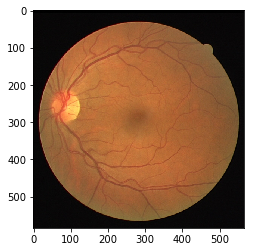

In [3]:
show_test_image()

In [4]:
# load the model
from keras.models import load_model
filepath = 'models/EliottNet.h5'
model = load_model(filepath)

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


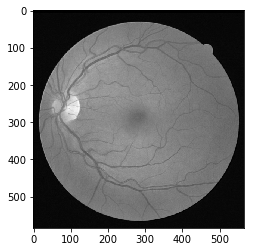

In [5]:
convert_test_to_grayscale()

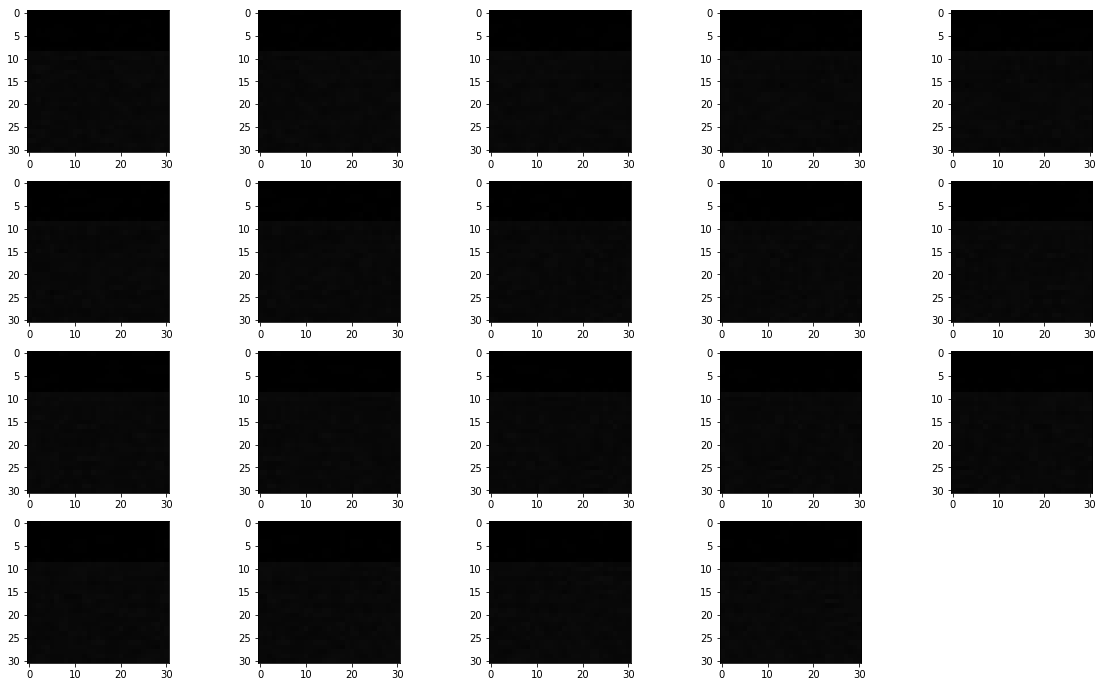

In [6]:
test_set = build_test_set(patchsize=31)

In [7]:
X_test = test_set['patches']
X_test.shape

(296390L, 31L, 31L)

In [8]:
X_test = X_test.reshape(X_test.shape[0], 1, 31, 31).astype('float32')
X_test.shape

(296390L, 1L, 31L, 31L)

In [29]:
pred = model.predict(X_test)

KeyboardInterrupt: 

In [9]:
%matplotlib inline
from myutils import *
import pickle

In [10]:
pred = pickle.load(open("pred.p", "rb"))
pred.shape

(296390L, 2L)

In [11]:
pred = pred[:,1]
heatmap = pred.reshape(554,535)

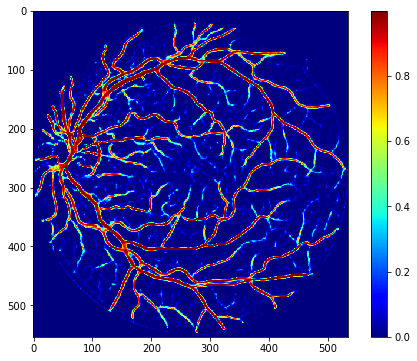

In [12]:
import matplotlib.pylab as plt
plt.figure(figsize=(8,6))
plt.imshow(heatmap, cmap="jet")
clb = plt.colorbar()
plt.show()

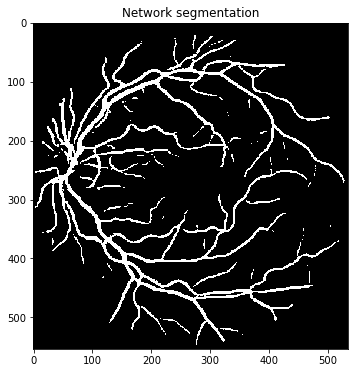

In [13]:
thresholded = pred>0.5
binarymask = thresholded.reshape(554,535)
plt.figure(figsize=(8,6))
plt.imshow(binarymask, cmap="gray")
plt.title("Network segmentation")
plt.show()

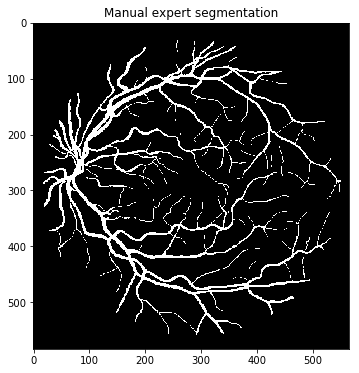

In [14]:
show_test_segmentation()

In [7]:
dataframe = quantitative_evaluation(binarymask, heatmap)
dataframe

myutils.py:325: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fov_heatmap = np.zeros((n_pixels_fov, 1))
myutils.py:326: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fov_binarymask = np.zeros((n_pixels_fov, 1))
myutils.py:327: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  fov_gt = np.zeros((n_pixels_fov, 1))


,AUC,Accuracy,Sensibility,Specificity
Predict all negative,Undefined,0.8689,Undefined,0.8689
Proposed method,0.9708,0.9436,0.7725,0.9695
